<a href="https://colab.research.google.com/github/Jakondo/Python-for-DL-and-CV/blob/master/Ch_8_CNN_PyTorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 8: Convolutional Neural Network - PyTorch

---



In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 19175595.84it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 328748.63it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5303194.49it/s]                           
8192it [00:00, 130326.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

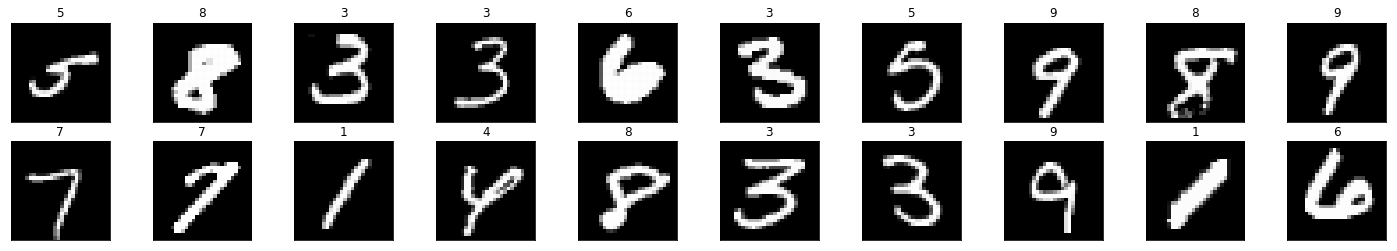

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)
    self.dropout1 = nn.Dropout(0.5) 
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)    
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [10]:
epochs = 15
loss_hist = []
correct_hist = []
val_loss_hist = []
val_cor_hist = []

for e in range(epochs):
  run_loss = 0.0
  run_correct = 0.0
  val_run_loss = 0.0
  val_run_cor = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)    
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    run_correct += torch.sum(preds == labels.data)    
    run_loss += loss.item()
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)    
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_run_cor += torch.sum(val_preds == val_labels.data)    
        val_run_loss += val_loss.item()
      
    epoch_loss = run_loss/len(training_loader)
    epoch_acc = run_correct.float()/len(training_loader)
    loss_hist.append(epoch_loss)
    correct_hist.append(epoch_acc)
    
    val_epoch_loss = val_run_loss/len(validation_loader)
    val_epoch_acc = val_run_cor.float()/len(validation_loader)
    val_loss_hist.append(val_epoch_loss)
    val_cor_hist.append(val_epoch_acc)
    
    print('epoch: ', (e+1))    
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 0.5711, accuracy 85.1150
validation loss: 0.1824, accuracy 94.5700
epoch:  2
training loss: 0.1488, accuracy 95.6833
validation loss: 0.0998, accuracy 97.1700
epoch:  3
training loss: 0.0998, accuracy 97.0017
validation loss: 0.0712, accuracy 97.7800
epoch:  4
training loss: 0.0773, accuracy 97.6250
validation loss: 0.0603, accuracy 98.1000
epoch:  5
training loss: 0.0657, accuracy 98.0383
validation loss: 0.0508, accuracy 98.4800
epoch:  6
training loss: 0.0571, accuracy 98.2617
validation loss: 0.0468, accuracy 98.5300
epoch:  7
training loss: 0.0499, accuracy 98.5100
validation loss: 0.0425, accuracy 98.6700
epoch:  8
training loss: 0.0432, accuracy 98.6967
validation loss: 0.0372, accuracy 98.6800
epoch:  9
training loss: 0.0387, accuracy 98.7867
validation loss: 0.0395, accuracy 98.6200
epoch:  10
training loss: 0.0367, accuracy 98.8983
validation loss: 0.0352, accuracy 98.8600
epoch:  11
training loss: 0.0346, accuracy 98.9633
validation loss: 0.0354, acc

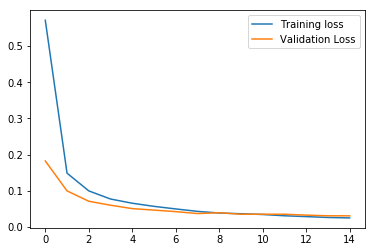

In [11]:
plt.plot(loss_hist, label='Training loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.legend();

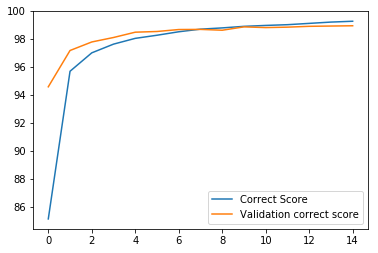

In [12]:
plt.plot(correct_hist, label='Correct Score')
plt.plot(val_cor_hist, label='Validation correct score')
plt.legend();

#Test

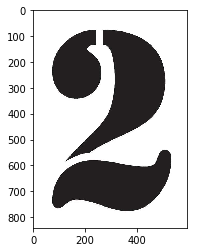

In [30]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://zabavnik.club/wp-content/uploads/2018/07/Krasivye_kartinki_cifr_dlya_pechati_4_15034633.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img);

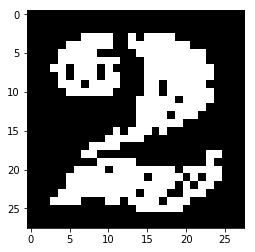

In [31]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [32]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

8


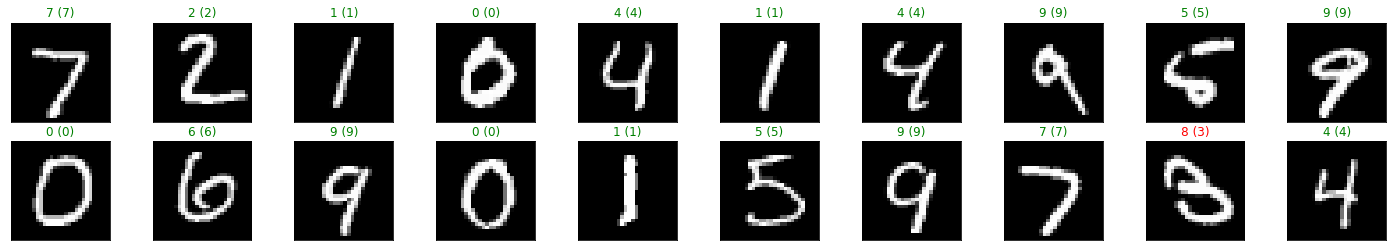

In [34]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))
  